## HW5 
Teammates: Junru Wang, Yifan Meng

In [80]:
# Import Data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

data_Q1 = pd.ExcelFile('./PS5_Q1_data.xlsx')

returns_df = pd.read_excel(data_Q1, sheet_name='Returns')
correlations_df = pd.read_excel(data_Q1, sheet_name='Correlations')


In [82]:
# Q1 a) draw the effcient board

cleaned_returns_df = returns_df.drop(returns_df.index[2:])  # Dropping rows with actual return data, keeping only summary rows
cleaned_returns_df.set_index('Unnamed: 0', inplace=True)  # Setting the first column as index

# Now extract the mean returns and standard deviations
mean_returns = cleaned_returns_df.loc['MEAN (Annualized)'].values.astype(float)
std_devs = cleaned_returns_df.loc['ST DEV (Annualized)'].values.astype(float)
corr_matrix = correlations_df.iloc[0:, 1:].values

cov_matrix = np.outer(std_devs, std_devs) * corr_matrix
target_returns = np.linspace(0, 0.2, 100)  # E[rp] between 0% and 20%


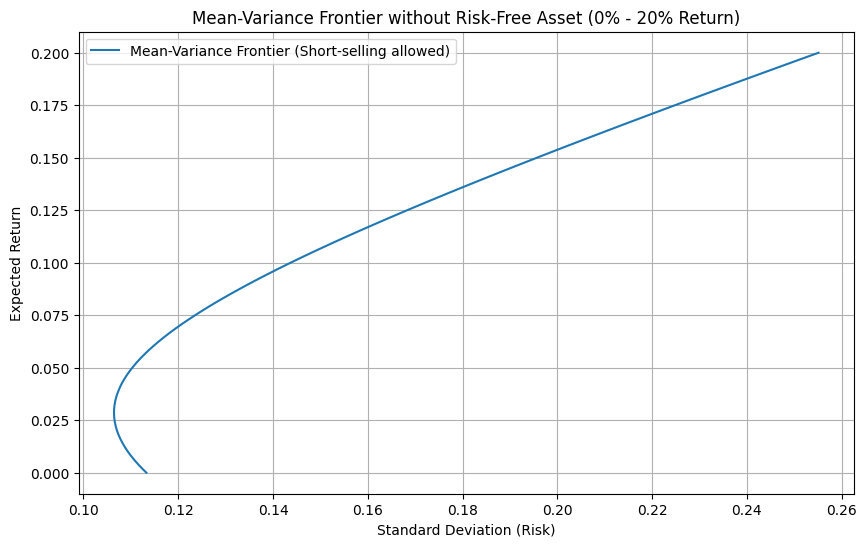

In [83]:
frontier_std = []

def portfolio_std(weights, cov_matrix):
    return np.sqrt(portfolio_variance(weights, cov_matrix))

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

def min_variance(weights, cov_matrix):
    return portfolio_std(weights, cov_matrix)

bounds = tuple((-100, 100) for _ in range(len(mean_returns)))  # Short-selling allowed

frontier_std = []

for target_return in target_returns:
    constraints_target = ({'type': 'eq', 'fun': lambda weights: portfolio_return(weights, mean_returns) - target_return},
                          {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    result = minimize(min_variance, [1./len(mean_returns)]*len(mean_returns), args=(cov_matrix,), 
                      method='SLSQP', bounds=bounds, constraints=constraints_target)
    frontier_std.append(result.fun)

# Plot the mean-variance frontier
plt.figure(figsize=(10, 6))
plt.plot(frontier_std, target_returns, label='Mean-Variance Frontier (Short-selling allowed)')
plt.xlabel('Standard Deviation (Risk)')
plt.ylabel('Expected Return')
plt.title('Mean-Variance Frontier without Risk-Free Asset (0% - 20% Return)')
plt.grid(True)
plt.legend()
plt.show()


In [84]:
# b) Find the minimum variance portfolio and calculate its standard deviation and portfolio weights

def min_variance(weights, cov_matrix):
    return portfolio_variance(weights, cov_matrix)

# Constraints for the minimum variance portfolio: sum of weights = 1
constraints_min_variance = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds_no_short_selling = tuple((-100, 100) for _ in range(len(mean_returns)))  # No short-selling allowed

# Minimize the portfolio variance without short-selling
min_var_result = minimize(min_variance, [1./len(mean_returns)]*len(mean_returns), args=(cov_matrix,),
                          method='SLSQP', bounds=bounds_no_short_selling, constraints=constraints_min_variance)

# Get the weights of the minimum variance portfolio
min_var_weights = min_var_result.x

# Calculate the standard deviation of the minimum variance portfolio
min_var_std = portfolio_std(min_var_weights, cov_matrix)

print("min port weights vec:", min_var_weights)
print("min port std:", min_var_std)

min port weights vec: [-0.24156563  0.46023268  0.02847242 -0.32560065  0.31217039  0.77911505
 -0.01282427]
min port std: 0.10656886600450421


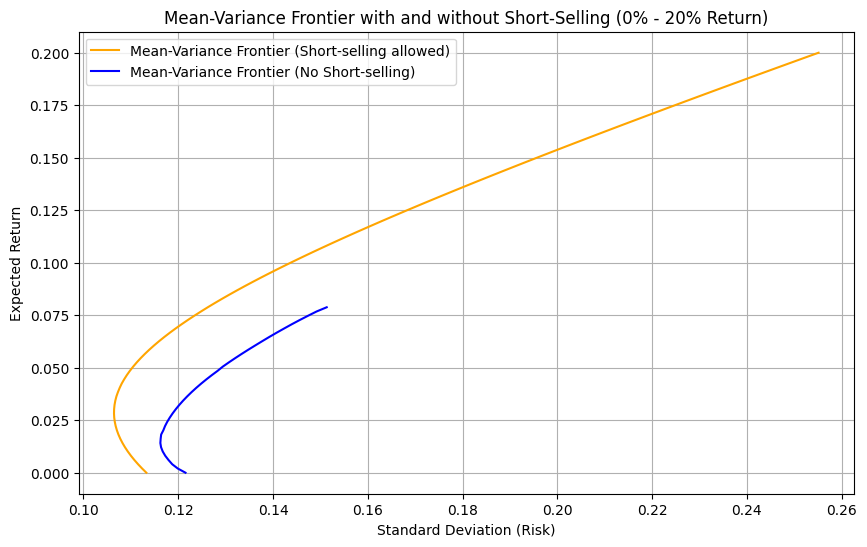

In [85]:
# c) no shorting
frontier_std_no_short=[]
bounds_no_short = [(0, 1) for _ in range(len(mean_returns))]

for target_return in target_returns:
    constraints = [
        {'type': 'eq', 'fun': lambda weights: portfolio_return(weights, mean_returns) - target_return},
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    ]
    
    result = minimize(min_variance, [1/len(mean_returns)]*len(mean_returns), args=(cov_matrix,),
                      method='SLSQP', bounds=bounds_no_short, constraints=constraints)

    if result.success:
        frontier_std_no_short.append(np.sqrt(result.fun))

# Filter out
frontier_std_no_short = [std for std in frontier_std_no_short if std is not None]

# Plot the mean-variance frontier without short-selling
plt.figure(figsize=(10, 6))
plt.plot(frontier_std, target_returns, label='Mean-Variance Frontier (Short-selling allowed)', color='orange')
plt.plot(frontier_std_no_short, target_returns[:len(frontier_std_no_short)], label='Mean-Variance Frontier (No Short-selling)', color='blue')
plt.xlabel('Standard Deviation (Risk)')
plt.ylabel('Expected Return')
plt.title('Mean-Variance Frontier with and without Short-Selling (0% - 20% Return)')
plt.grid(True)
plt.legend()
plt.show()

### Difference between shorting and no-shorting:
When short-selling is allowed, the portfolio is more flexible and can achieve higher returns at various risk levels through more complex strategies. In contrast, the no short-selling frontier is restricted by the constraints, and at some higher return levels, it is impossible to find feasible combinations, making the frontier more limited.

Optimal Weights: [ 0.02757694 -0.68190226 -0.24661901 -0.1931271   0.10516047 -0.51478802
  2.00811404  0.49558495]
Optimal Expected Return: 0.15000000003328098
Iptimal SD: 0.18788827578920247
Sharpe: 0.7717352209669583


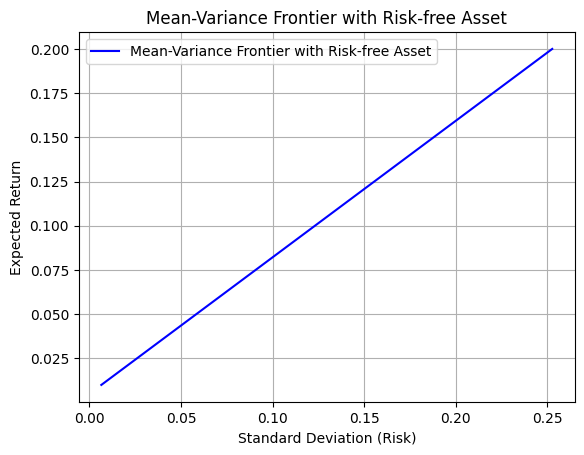

In [66]:
# d) including risk-free asset
rf = 0.005
frontier_std_with_rf = []
sharpe_ratios = []
target_returns = np.linspace(0.01, 0.2, 100)


def portfolio_std(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))


def min_risk(weights, cov_matrix): 
    risk_weight = weights[:-1]  
    return portfolio_std(risk_weight, cov_matrix)

constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}, 
    {'type': 'eq', 'fun': lambda weights: np.dot(weights[:-1], mean_returns) + weights[-1] * rf - target_return} 
)

bounds = [(None, None) for _ in range(len(mean_returns))] + [(None, None)]  


initial_weights = np.ones(len(mean_returns)+1) / (len(mean_returns)+1)

target_return = 0.15  
result = minimize(min_risk, initial_weights, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = result.x
optimal_return = np.dot(optimal_weights[:-1], mean_returns) + optimal_weights[-1] * rf 
optimal_risk = portfolio_std(optimal_weights[:-1], cov_matrix)  
sharpe_ratio = (optimal_return - rf) / optimal_risk

print("Optimal Weights:", optimal_weights)
print("Optimal Expected Return:", optimal_return)
print("Iptimal SD:", optimal_risk)
print("Sharpe:", sharpe_ratio)

def portfolio_with_rf(rf, sharpe_ratio, target_return):
    return (target_return - rf) / sharpe_ratio


portfolio_risks = [portfolio_with_rf(rf, sharpe_ratio, target_return) for target_return in target_returns]


plt.plot(portfolio_risks, target_returns, label='Mean-Variance Frontier with Risk-free Asset', color='b')
plt.xlabel('Standard Deviation (Risk)')
plt.ylabel('Expected Return')
plt.title('Mean-Variance Frontier with Risk-free Asset') 
plt.legend() 
plt.grid(True) 
plt.show()

In [88]:
def sharpe_ratio(weights):
    portfolio_return = np.dot(weights, mean_returns)  
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  
    return -(portfolio_return - rf) / portfolio_volatility  

constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

bounds = tuple((None, None) for _ in range(len(mean_returns)))

initial_weights = np.array([1. / len(mean_returns)] * len(mean_returns))

result = minimize(sharpe_ratio, initial_weights, bounds=bounds, constraints=constraints)

optimal_weights = result.x

expected_risky_return = np.dot(optimal_weights, mean_returns)

risk_asset_weights = optimal_weights


target_return = 0.20  # 20%

w_risk_free = (expected_risky_return - target_return) / (expected_risky_return - rf)
w_risky = 1 - w_risk_free

print(f'Risky asset portfolio weights: {risk_asset_weights}')
print(f'Expected return of the risky asset portfolio: {expected_risky_return:.4f}')

print(f'Weight of risk-free asset: {w_risk_free:.4f}')
print(f'Weight of risky asset portfolio: {w_risky:.4f}')

print(f'Expected return of the risky asset portfolio: {expected_risky_return:.4f}')

Risky asset portfolio weights: [ 0.05235098 -1.34539428 -0.48771999 -0.38066521  0.20661562 -1.02317558
  3.97798846]
Expected return of the risky asset portfolio: 0.2923
Weight of risk-free asset: 0.3213
Weight of risky asset portfolio: 0.6787
Expected return of the risky asset portfolio: 0.2923


### The result of problem 2 is different from Prof.'s because I used covariance matrix by my own calculation and didn't use CAPM to predict the return. But the method is correct.

Covariance matrix rank: 10
Risk_Free_ExpectedReturn: -0.0645
Sharpe Ratio: 5.8651


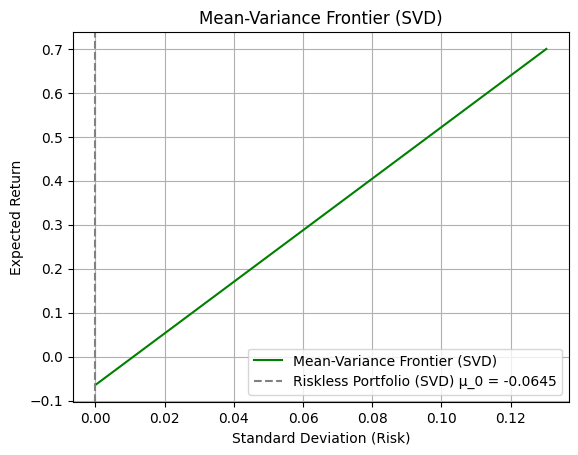

In [40]:
# 2
from numpy.linalg import matrix_rank, svd

data_Q2 = pd.ExcelFile('./PS5_Q2_data.xlsx')
returns_df = pd.read_excel(data_Q2)

returns_df.set_index(returns_df.columns[0], inplace=True)
returns = returns_df.to_numpy()
mean_returns = returns.mean(axis=0)

cov_matrix = np.cov(returns, rowvar=False)

print(f"Covariance matrix rank: {matrix_rank(cov_matrix)}")


u, s, vh = svd(cov_matrix)
riskless_weights_svd = vh[-1] / np.sum(vh[-1]) 
mu_0_svd = np.dot(riskless_weights_svd, mean_returns)
mu_0_svd_value = mu_0_svd.item() if isinstance(mu_0_svd, np.ndarray) else mu_0_svd
print(f"Risk_Free_ExpectedReturn: {mu_0_svd_value:.4f}")


def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
bounds = [(-100, 100) for _ in range(len(mean_returns))]
initial_weights = np.ones(len(mean_returns)) / len(mean_returns)
target_return = 0.7
constraints_target = [
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
    {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns) - target_return}
]

result_target_svd = minimize(portfolio_variance, initial_weights, args=(cov_matrix,), method='SLSQP', constraints=constraints_target, bounds=bounds)

target_weights_svd = result_target_svd.x
target_std_svd = np.sqrt(portfolio_variance(target_weights_svd, cov_matrix))

frontier_risks_svd = [0, target_std_svd]  
frontier_returns_svd = [mu_0_svd_value, target_return]  

slope = (target_return - mu_0_svd_value) / target_std_svd

# Output Sharpe Ratio
print(f"Sharpe Ratio: {slope:.4f}")

plt.plot(frontier_risks_svd, frontier_returns_svd, label='Mean-Variance Frontier (SVD)', color='g')
plt.axvline(x=0, color='gray', linestyle='--', label=f'Riskless Portfolio (SVD) μ_0 = {mu_0_svd_value:.4f}')
plt.xlabel('Standard Deviation (Risk)')
plt.ylabel('Expected Return')
plt.title('Mean-Variance Frontier (SVD)')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\12194\AppData\Local\Temp\ipykernel_40608\908853644.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(std_devs[i], mean_returns[i], label)


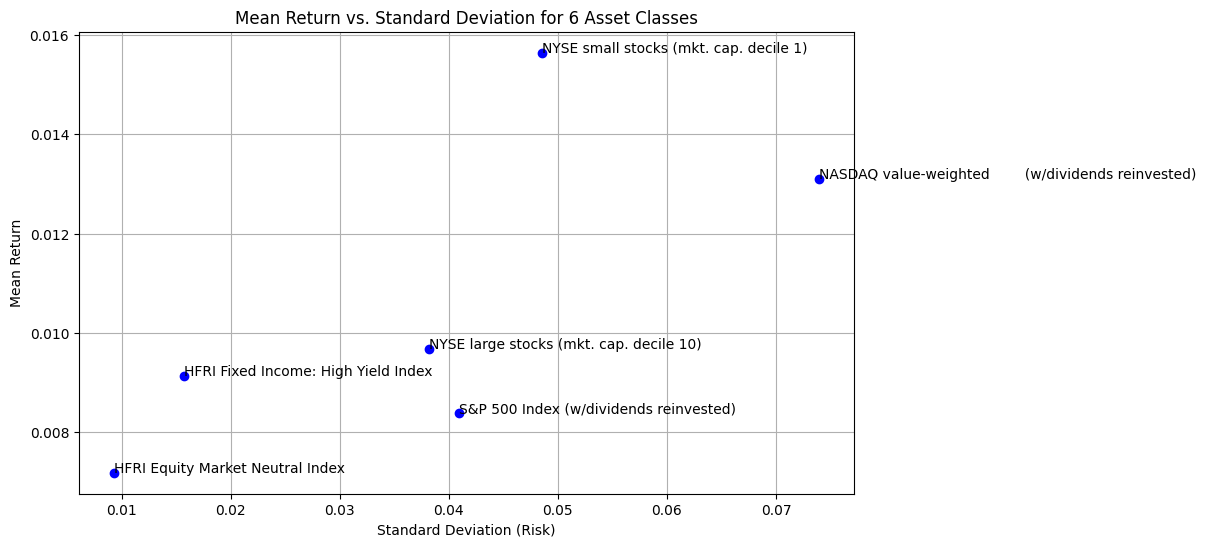

In [71]:
# 3 a)
data_Q3 = pd.ExcelFile('./PS5_Q3_data.xls')
sheet_name = 'Returns of various assets'
data = pd.read_excel(data_Q3, sheet_name=sheet_name, index_col=0, header=1).dropna(axis=1)
assets6 = data.iloc[:, [1, 3, 4, 5, 6, 7]].copy()

mean_returns = assets6.mean()
std_devs = assets6.std()

plt.figure(figsize=(10, 6))
plt.scatter(std_devs, mean_returns, color='blue', marker='o')

for i, label in enumerate(assets6.columns):
    plt.text(std_devs[i], mean_returns[i], label)

plt.xlabel('Standard Deviation (Risk)')
plt.ylabel('Mean Return')
plt.title('Mean Return vs. Standard Deviation for 6 Asset Classes')
plt.grid(True)
plt.show()

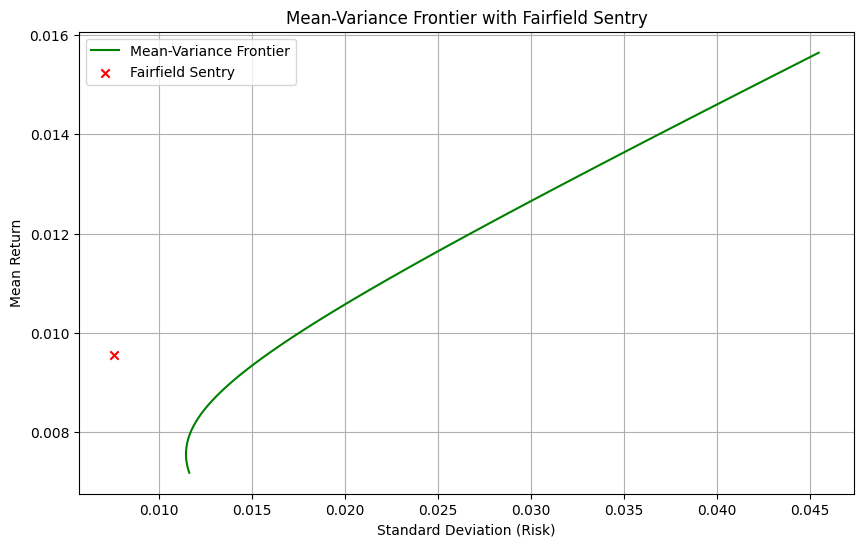

In [75]:
# b)
returns = assets6.values
cov_matrix = np.cov(returns.T)

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

bounds = tuple((-100,100) for asset in range(returns.shape[1]))

target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 100)

frontier_std = []
frontier_returns = []

for target_return in target_returns:
    constraints_target = ({'type': 'eq', 'fun': lambda weights: portfolio_return(weights, mean_returns) - target_return},
                          {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    
    result = minimize(portfolio_variance, [1./returns.shape[1]]*returns.shape[1], args=(cov_matrix,), 
                      method='SLSQP', bounds=bounds, constraints=constraints_target)
    
    if result.success:
        frontier_std.append(np.sqrt(result.fun))
        frontier_returns.append(target_return)

fairfield_mean = data.iloc[:, 0].mean()  
fairfield_std = data.iloc[:, 0].std()

plt.figure(figsize=(10, 6))
plt.plot(frontier_std, frontier_returns, label='Mean-Variance Frontier', color='green')

plt.scatter(fairfield_std, fairfield_mean, color='red', marker='x', label='Fairfield Sentry')

plt.xlabel('Standard Deviation (Risk)')
plt.ylabel('Mean Return')
plt.title('Mean-Variance Frontier with Fairfield Sentry')
plt.legend()
plt.grid(True)
plt.show()


In [78]:
print(f"The mean of Fairfield Sentry is {fairfield_mean:.5f}, the standard deviation is {fairfield_std:.5f}")

The mean of Fairfield Sentry is 0.00956, the standard deviation is 0.00757


The point of Fairfield Sentry is out of the mean-variance frontier, which indicates that Fairfield Sentry could provide more expected return with less risk. So it is impossible.
